In [1]:
#%pip install --no-cache-dir ttAugment
#%pip install --no-cache-dir building-footprint-segmentation

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall numpy 1.19.2, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.19.2'.


In [3]:
import cv2
import torch
import numpy as np

import os
import sys
sys.path.append("/home/leadawon5/dawon/vision/dacon/building-footprint-segmentation")

from building_footprint_segmentation.seg.binary.models import DLinkNet34
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model
)
from torch.utils import model_zoo
from tt_augment.augment import generate_seg_augmenters

%matplotlib inline 
from matplotlib import pyplot as plt


In [4]:
def get_model():
    model = DLinkNet34()
    state_dict = model_zoo.load_url(r"https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/v0.2.3/DlinkNet.zip", progress=True, map_location="cpu")
    state_dict = adjust_model(state_dict["model"])
    model.load_state_dict(state_dict)
    return model

In [15]:
IMG_PTH = "/home/leadawon5/dawon/vision/dacon/building-footprint-segmentation/data/schange/test/images/22828930_15.png"

TRANSFORMATION_TO_APPLY = [
  {"name": "Mirror", "crop_to_dimension": (224, 224)},
  {"name": "CropScale", "crop_to_dimension": (224, 224)},
]


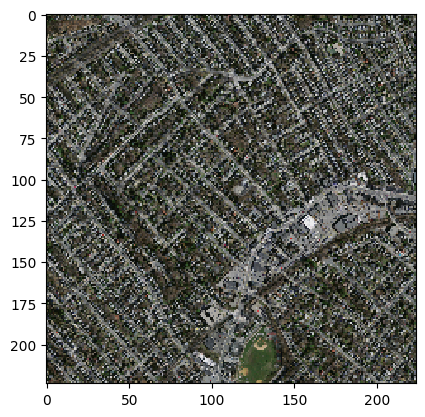

In [16]:
original_image = cv2.imread(IMG_PTH)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image, interpolation='nearest')
plt.show()

In [17]:
image = min_max_image_net(img=original_image)
image = np.expand_dims(image, 0)

h, w, _ = original_image.shape
number_of_output_channels = 1

tta = generate_seg_augmenters(
            image=image,
            window_size=(256, 256),
            output_dimension=(1, h, w, number_of_output_channels),
            transformation_to_apply=TRANSFORMATION_TO_APPLY,
        )

model = get_model()

In [18]:
for iterator, transformation in enumerate(tta):
    for augmented_fragment in transformation.transform_fragment():
        tensor_image = to_input_image_tensor(augmented_fragment).swapaxes(0, 1)

        with torch.no_grad():
            # Perform prediction
            prediction = model(tensor_image)
            prediction = prediction.sigmoid()
            
            prediction_binary = convert_tensor_to_numpy(prediction.swapaxes(-1, 1))
            transformation.restore_fragment(prediction_binary)

tta.merge()

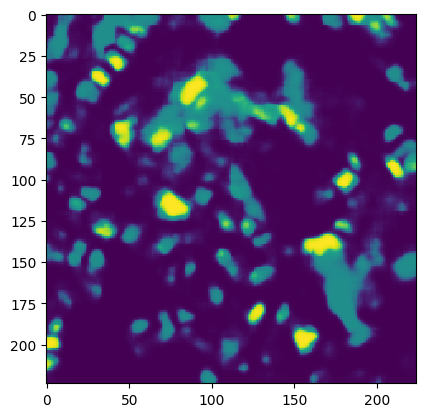

In [19]:
output = tta.tta_output()
plt.imshow(output[0], interpolation='nearest')
plt.show()